# Libraries

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
from skimage import io, transform
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, models
from torchmetrics import F1Score
from torchvision import transforms, utils, models
from torchsummary import summary

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm
import segmentation_models_pytorch as smp
import cv2

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

/home/francesco/anaconda3/envs/pyt/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


# Detection

## Dataset

### Normal

In [3]:
seg_transform = transforms.Compose([transforms.ToTensor()])
seg_transform_mask = transforms.Compose([transforms.ToTensor()])

In [4]:
class ApplesDatasetDetection(Dataset):
    """Apples Dataset"""

    def __init__(self, root_dir, train=True, transform=None, transform_img=None, padding=False, padding_type="constant"):
        """
        Args:
            root_dir (string): Directory with all the images.
            train (bool, optional): True if we want to create the training dataset, False for the test dataset
            transform (callable, optional): Optional transform to be applied on a sample.
            padding (bool, optional): To apply a padding on the images (both image and mask)
            padding_type(str): Which type of padding to use
        """
        self.train = train
        self.root_dir = root_dir
        folderIM_content = np.sort(os.listdir(self.root_dir+"/images"))
        if self.train: 
            folderMA_content = np.sort(os.listdir(self.root_dir+"/masks"))
            self.summary = pd.DataFrame({ "images": folderIM_content, "index": np.arange(len(folderIM_content)),"masks": folderMA_content})
        else:
            self.summary = pd.DataFrame({ "images": folderIM_content, "index": np.arange(len(folderIM_content))})
        self.padding = padding
        self.padding_type = padding_type
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.summary)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,'images',
                                self.summary.iloc[idx, 0])
        image = io.imread(img_name)

        if self.padding:
            if self.padding_type=='constant':
                image = np.pad(image, ((0,0), (8,8), (0,0)), self.padding_type, constant_values=0)
            else:
                image = np.pad(image, ((0,0), (8,8), (0,0)), self.padding_type)

        if self.train:
            mask_name = os.path.join(self.root_dir,'masks',
                                    self.summary.iloc[idx, 0])
            mask = io.imread(mask_name)
            mask[mask>0]=255

            if self.padding:
                if self.padding_type=='constant':
                    mask = np.pad(mask, ((0,0), (8,8)), self.padding_type, constant_values=0)
                else:
                    mask = np.pad(mask, ((0,0), (8,8)), self.padding_type)

            sample = [image, mask]
        else:
            sample = [image]

        if self.transform:
            state = torch.get_rng_state()
            sample[0] = self.transform(sample[0])
            if self.train:
                torch.set_rng_state(state)
                sample[1] =self.transform(sample[1])
            if self.transform_img:
                sample[0] = self.transform_img(sample[0])
        

        return sample

DETECTION
Total dataset dimension: 670
Test dataset dimension: 331
Train dataset dimension: 603
Val dataset dimension: 67
Image size: (3, 1280, 736)
Mask size: (1, 1280, 736)


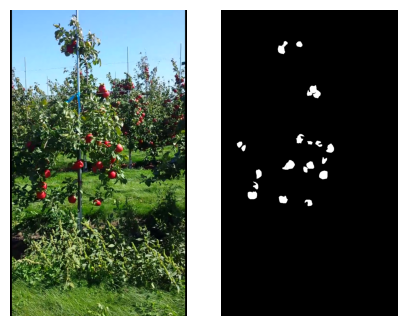

In [5]:
#DETECTION
#dataset creation
print("DETECTION")
root = "./"

AppDetect_train = ApplesDatasetDetection(root_dir=root+"detection/train", 
                                         transform=seg_transform, 
                                         transform_img=None,
                                         padding=True)

AppDetect_test = ApplesDatasetDetection(root_dir=root+"test_data/segmentation",
                                        train=True,
                                        transform=seg_transform,
                                        transform_img=None,
                                        padding=True)

print(f"Total dataset dimension: {len(AppDetect_train)}")
print(f"Test dataset dimension: {len(AppDetect_test)}")

#train-val split
np.random.seed(0)
torch.manual_seed(10)

train_dim=int(len(AppDetect_train)*0.9)
val_dim=int(len(AppDetect_train)-train_dim)

AppD_train, AppD_val = random_split(AppDetect_train, [train_dim, val_dim])

print(f"Train dataset dimension: {len(AppD_train)}")
print(f"Val dataset dimension: {len(AppD_val)}")

#print demostrative images
index = np.random.randint(len(AppD_train))

print("Image size: " + str(AppD_train[0][0].numpy().shape))
print("Mask size: " + str(AppD_train[0][1].numpy().shape))

_, axDec = plt.subplots(1,2, figsize=(5,4)) 
axDec[0].imshow(AppDetect_train[index][0].permute(1,2,0))
axDec[0].axis("off")
axDec[1].imshow(AppDetect_train[index][1].permute(1,2,0), cmap="gray")
axDec[1].axis("off")
plt.show()

In [6]:
# creating dataloaders
batch_size = 5

AppD_train_dataloader = DataLoader(AppD_train, batch_size=batch_size, shuffle=True, num_workers=0)
AppD_val_dataloader = DataLoader(AppD_val, batch_size=batch_size, shuffle=True, num_workers=0)
AppD_test_dataloader = DataLoader(AppDetect_test, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Number of train batches: {len(AppD_train_dataloader)}")
print(f"Number of val batches: {len(AppD_val_dataloader)}")
print(f"Number of test batches: {len(AppD_test_dataloader)}")

Number of train batches: 121
Number of val batches: 14
Number of test batches: 67


### Augmented

In [7]:
seg_aug_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.RandomHorizontalFlip(p=0.5)])

seg_aug_transform_img = transforms.ColorJitter(brightness=(0.7,1.3))

In [8]:
#DETECTION
#dataset creation
print("DETECTION AUGMENTED")
root = "./"

AppDetect_train_aug = ApplesDatasetDetection(root_dir=root+"detection/train", 
                                             transform=seg_aug_transform, 
                                             transform_img=seg_aug_transform_img,
                                             padding=True)

AppDetect_test_aug = ApplesDatasetDetection(root_dir=root+"detection/test",
                                            train=False,
                                            transform=seg_aug_transform, 
                                            padding=True)

#train-val split

AppD_train_aug, AppD_val_aug = random_split(AppDetect_train_aug, [train_dim, val_dim])

batch_size_aug = 5

AppD_train_dataloader_aug = DataLoader(AppD_train_aug, batch_size=batch_size_aug, shuffle=True, num_workers=0)
AppD_val_dataloader_aug = DataLoader(AppD_val_aug, batch_size=batch_size_aug, shuffle=True, num_workers=0)
AppD_test_dataloader_aug = DataLoader(AppDetect_test_aug, batch_size=batch_size_aug, shuffle=False, num_workers=0)

DETECTION AUGMENTED


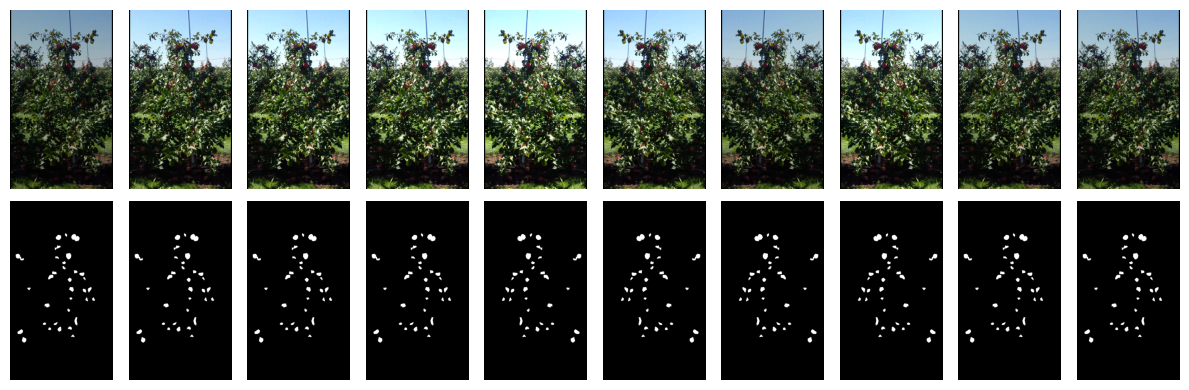

In [9]:
_, ax_aug = plt.subplots(2,10, figsize=(12,4))

for i in range(len(ax_aug[0,:])):
    sample = AppD_train_aug[0]
    ax_aug[0,i].imshow(sample[0].permute(1,2,0))
    ax_aug[0,i].axis("off")
    
    ax_aug[1,i].imshow(sample[1][0], cmap ="gray")
    ax_aug[1,i].axis("off")
    

plt.tight_layout()

## Model SMP

In [10]:
model_smp = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
#   activation="sigmoid"            # no need of sigmoid activation beacause we use BCE with logits loss function
)
#model_smp

In [11]:
#summary(model_smp.to(device),input_size=(3,1280,736))

In [12]:
# using segmentation models pytorch

model_smp = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
#   activation="sigmoid"            # no need of sigmoid activation beacause we use BCE with logits loss function
)


# choose trainable parameters
for param_name, param in model_smp.named_parameters():
    param.requires_grad = False  

for param_name, param in model_smp.encoder.layer4.named_parameters():
    param.requires_grad = True

for param_name, param in model_smp.decoder.named_parameters():
    param.requires_grad = True

for param_name, param in model_smp.segmentation_head.named_parameters():
    param.requires_grad = True

### Training

#### Metrices

In [13]:
#IoU METRIC

@metrics.default_for_key('IoU')
@metrics.running_mean
@metrics.mean
class IoU(Metric):
    """Binary accuracy metric. Uses torch.eq to compare predictions to targets. Decorated with a mean and running_mean.
    Default for key: 'binary_acc'.
    Args:
        pred_key (StateKey): The key in state which holds the predicted values
        target_key (StateKey): The key in state which holds the target values
        threshold (float): value between 0 and 1 to use as a threshold when binarizing predictions and targets
    """

    def __init__(self, pred_key=torchbearer.Y_PRED, target_key=torchbearer.Y_TRUE, threshold=0.5):
        self.pred_key = pred_key
        self.target_key = target_key

        self.threshold = threshold
        self.name="IoU"

    def process(self, *args):
        state=args[0]
        y_pred_bin = (state[self.pred_key]>0.5).float()
        overlap = torch.min(y_pred_bin + state[self.target_key], torch.ones_like(y_pred_bin))
        intersection = state[self.target_key]*y_pred_bin

        return (intersection.sum()/overlap.sum()).mean().float()

In [14]:
#IoU METRIC

@metrics.default_for_key('F1')
@metrics.running_mean
@metrics.mean
class F1(Metric):
    """Binary accuracy metric. Uses torch.eq to compare predictions to targets. Decorated with a mean and running_mean.
    Default for key: 'binary_acc'.
    Args:
        pred_key (StateKey): The key in state which holds the predicted values
        target_key (StateKey): The key in state which holds the target values
        threshold (float): value between 0 and 1 to use as a threshold when binarizing predictions and targets
    """

    def __init__(self, pred_key=torchbearer.Y_PRED, target_key=torchbearer.Y_TRUE, threshold=0.5):
        self.pred_key = pred_key
        self.target_key = target_key
        self.name="F1"
        self.score = F1Score("binary").to(device)

    def process(self, *args):
        state=args[0]
        y_pred_bin = (state[self.pred_key]>0.5).float().to(device)
        y_true = (state[self.target_key]>0.5).float().to(device)
        return self.score(y_pred_bin, y_true).to(device)

#### Normal dataset

In [15]:
np.random.seed(0)
torch.manual_seed(10)



check_best = Best('checkpoints/UNet_bear_best_F1.pth', monitor='val_IoU', mode='max')
check_last = ModelCheckpoint('checkpoints/UNet_bear_last_F1.pth')

model_smp = model_smp.to(device)

trial_seg = Trial(model_smp,
                 optim.Adam(model_smp.parameters(), lr=5e-04), 
                 nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.045]).to(device)), 
                 metrics=["loss", "acc", "IoU", "F1"],
                 callbacks=[check_best, check_last]).to(device)


trial_seg.load_state_dict(torch.load("checkpoints/UNet_bear_last_F1.pth"))
print("net loaded")

net loaded


In [16]:
trial_seg.with_generators(train_generator=AppD_train_dataloader, 
                          val_generator=AppD_val_dataloader, 
                          test_generator=AppD_test_dataloader)

mytrial_seg = trial_seg.run(epochs=100, verbose=1)

100%|##########| 100/100 [00:00<?, ?it/s]

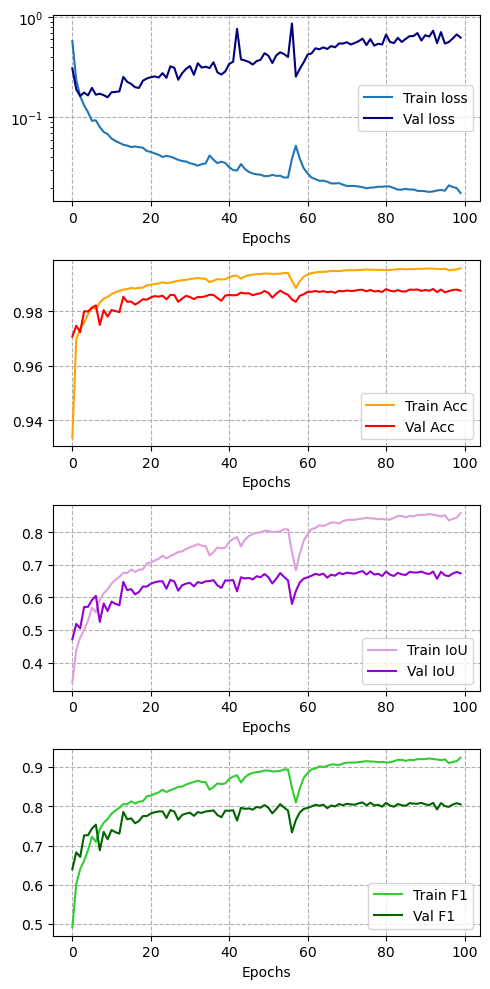

In [17]:
#np.savetxt(X=)

__, ax = plt.subplots(4,1,figsize=(5,10))

ax[0].semilogy([mt["loss"] for mt in mytrial_seg], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial_seg], label="Val loss", color="navy")

ax[1].plot([mt["binary_acc"] for mt in mytrial_seg], label="Train Acc", color="orange")
ax[1].plot([mt["val_binary_acc"] for mt in mytrial_seg], label="Val Acc", color="red")

ax[2].plot([mt["IoU"] for mt in mytrial_seg], label="Train IoU", color="plum")
ax[2].plot([mt["val_IoU"] for mt in mytrial_seg], label="Val IoU", color="darkviolet")

ax[3].plot([mt["F1"] for mt in mytrial_seg], label="Train F1", color="limegreen")
ax[3].plot([mt["val_F1"] for mt in mytrial_seg], label="Val F1", color="darkgreen")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Segmetation_train.png")

#### Augmented dataset

In [18]:
np.random.seed(0)
torch.manual_seed(10)



check_best_aug = Best('checkpoints/UNet_aug_bear_best.pth', monitor='val_IoU', mode='max')
check_last_aug = ModelCheckpoint('checkpoints/UNet_aug_bear_last.pth')

model_smp = model_smp.to(device)

trial_seg_aug = Trial(model_smp,
                 optim.Adam(model_smp.parameters(), lr=5e-04), 
                 nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.045]).to(device)), 
                 metrics=["loss", "acc", "IoU", "F1"],
                 callbacks=[check_best_aug, check_last_aug]).to(device)


trial_seg_aug.load_state_dict(torch.load("checkpoints/UNet_aug_bear_last.pth"))
print("net loaded")

net loaded


In [19]:
trial_seg_aug.with_generators(train_generator=AppD_train_dataloader_aug, 
                          val_generator=AppD_val_dataloader_aug, 
                          test_generator=AppD_test_dataloader_aug)

mytrial_seg_aug = trial_seg_aug.run(epochs=100, verbose=2)

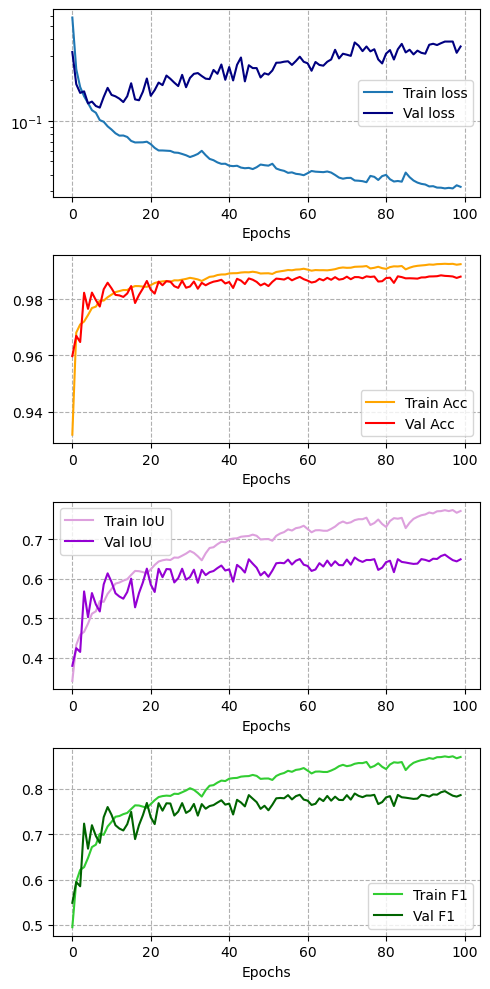

In [20]:

__, ax = plt.subplots(4,1,figsize=(5,10))

ax[0].semilogy([mt["loss"] for mt in mytrial_seg_aug], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial_seg_aug], label="Val loss", color="navy")

ax[1].plot([mt["binary_acc"] for mt in mytrial_seg_aug], label="Train Acc", color="orange")
ax[1].plot([mt["val_binary_acc"] for mt in mytrial_seg_aug], label="Val Acc", color="red")

ax[2].plot([mt["IoU"] for mt in mytrial_seg_aug], label="Train IoU", color="plum")
ax[2].plot([mt["val_IoU"] for mt in mytrial_seg_aug], label="Val IoU", color="darkviolet")

ax[3].plot([mt["F1"] for mt in mytrial_seg_aug], label="Train F1", color="limegreen")
ax[3].plot([mt["val_F1"] for mt in mytrial_seg_aug], label="Val F1", color="darkgreen")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Segmetation_train_aug.png")

### Show Results

In [21]:
def plotSegMask(sample, mytrial, checkpoint=True, plot=True):
    if checkpoint:
        model_smp = mytrial.state[torchbearer.state.MODEL]
    else:
        model_smp.load_state_dict(torch.load(seg_state_dict))
    model_smp.eval()

    image = sample[0]
    mask = sample[1]
    out = nn.Sigmoid()(model_smp(image.unsqueeze(0).to(device)).detach().cpu())
    out = (out>0.5).float()
    
    if plot:
        _, ax = plt.subplots(1,3, figsize=(10,5))

        ax[0].imshow(image.permute(1,2,0))
        ax[0].set_title("Original", fontweight="bold")
        ax[1].imshow(out[0][0], cmap="gray")
        ax[1].set_title("Segmentation output", fontweight="bold")
        ax[2].imshow(mask[0], cmap="gray")
        ax[2].set_title("Ground truth", fontweight="bold")

        [axi.axis("off") for axi in ax.flatten()]
        plt.tight_layout()

    return out[0], mask

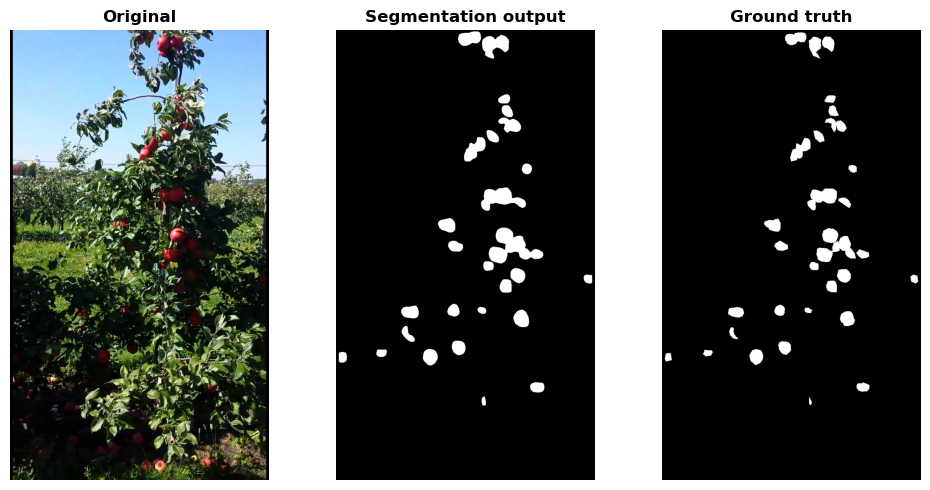

In [22]:
seg_prova, mask_prova = plotSegMask(sample = AppD_val[17],
                                    mytrial = trial_seg_aug)

## Model Skretch

In [23]:
def ConvBlock(input_channels, output_channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, input_channels, kernel_size=5, padding=2),
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Dropout(0.15),

        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(),
    )

In [24]:
class ConvBlock(nn.Module):
    def __init__(self,input_channels, output_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, input_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
        )

    def forward(self,x):
        return self.conv(x)


class ConvTransBlock(nn.Module):
    def __init__(self,input_channels, output_channels):
        super(ConvTransBlock, self).__init__()
    
        self.convtrans = nn.Sequential(

              nn.ConvTranspose2d(input_channels,input_channels, stride=2,kernel_size=3, padding=1, output_padding=1),
              nn.BatchNorm2d(input_channels),
              nn.LeakyReLU(),
              nn.Dropout(0.15),
        )

        self.conv = nn.Sequential(

              nn.Conv2d(input_channels*2, input_channels,kernel_size=3, padding=1),
              nn.BatchNorm2d(input_channels),
              nn.LeakyReLU(),

              nn.Conv2d(input_channels, output_channels,kernel_size=3, padding=1),
              nn.BatchNorm2d(output_channels),
              nn.LeakyReLU(),
        )

    def forward(self,x,skip_connection):
        x = self.convtrans(x)
        x = torch.cat([x,skip_connection],1)
       #print(x.shape)
        x = self.conv(x)
        return x

class Bottleneck(nn.Module):
    def __init__(self,channels):
        super(Bottleneck,self).__init__()
        self.conv = nn.Sequential(

          nn.Conv2d(channels, channels*2, kernel_size= 3, padding = 1),
          nn.BatchNorm2d(channels*2),
          nn.ReLU(),
          nn.Dropout(0.15),
          nn.Conv2d(channels*2, channels, kernel_size= 3, padding = 1),
          nn.BatchNorm2d(channels),
          nn.ReLU(),
      )
    def forward(self, x):
        return self.conv(x)


class my_UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(my_UNet,self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.convblock1 = ConvBlock(self.input_channels,32)
        self.convblock2 = ConvBlock(32,64)
        self.convblock3 = ConvBlock(64,128)
        self.convblock4 = ConvBlock(128,256)
        self.pooling = nn.MaxPool2d(2)

        self.bottleneck = Bottleneck(256)

        self.convtrans1 = ConvTransBlock(256,128)
        self.convtrans2 = ConvTransBlock(128,64)
        self.convtrans3 = ConvTransBlock(64,32)
        self.convtrans4 = ConvTransBlock(32,32)


        self.finalconv = nn.Conv2d(32,self.output_channels,kernel_size=1)

    def forward(self, x):
        #print("shape of x: ",x.shape)

        skip_connections = []

        #[10, 3, 1280, 736]
        x = self.convblock1(x)
        skip_connections.append(x)
        x = self.pooling(x)
        #print("shape of x: ",x.shape)

        #[10, 32, 640, 368]
        x = self.convblock2(x)
        skip_connections.append(x)
        x = self.pooling(x) 
        #print("shape of x: ",x.shape)

        #[10,64,320,184]
        x = self.convblock3(x)
        skip_connections.append(x)
        x = self.pooling(x)
        #print("shape of x: ",x.shape)

        #[10, 128, 160, 92]
        x = self.convblock4(x)
        skip_connections.append(x)
        x = self.pooling(x)
        #print("shape of x: ",x.shape)

        #[10, 256, 80, 46]
        x = self.bottleneck(x)
        #print("shape of x: ",x.shape)
        #print("shape of skip connections: ",skip_connections[-1].shape)
        #y = torch.cat([x,skip_connections[-1]],1)
        y = self.convtrans1(x,skip_connections[-1])

        #y = torch.cat([y,skip_connections[-2]],1)
        y = self.convtrans2(y,skip_connections[-2])

        #y = torch.cat([y,skip_connections[-3]],1)
        y = self.convtrans3(y,skip_connections[-3])

        #y = torch.cat([y,skip_connections[-4]],1)
        y = self.convtrans4(y,skip_connections[-4])

        y = self.finalconv(y)

        return y

In [25]:
model = my_UNet()

### Training

### Normal dataset

In [26]:
np.random.seed(0)
torch.manual_seed(10)



check_skretch_best = Best('checkpoints/Skretch_UNet_aug_bear_best.pth', monitor='val_IoU', mode='max')
check_skretch_last = ModelCheckpoint('checkpoints/Skretch_UNet_aug_bear_last.pth')

model_skretch = model.to(device)

trial_seg_skretch = Trial(model_skretch,
                 optim.Adam(model_skretch.parameters(), lr=5e-04), 
                 nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.045]).to(device)), 
                 metrics=["loss", "acc", "IoU", "F1"],
                 callbacks=[check_skretch_best, check_skretch_last]).to(device)


trial_seg_skretch.load_state_dict(torch.load("checkpoints/Skretch_UNet_bear_best.pth"))
print("net loaded")

net loaded


In [27]:
trial_seg_skretch.with_generators(train_generator=AppD_train_dataloader, 
                          val_generator=AppD_val_dataloader, 
                          test_generator=AppD_test_dataloader)

mytrial_seg_skretch = trial_seg_skretch.run(epochs=40, verbose=2)

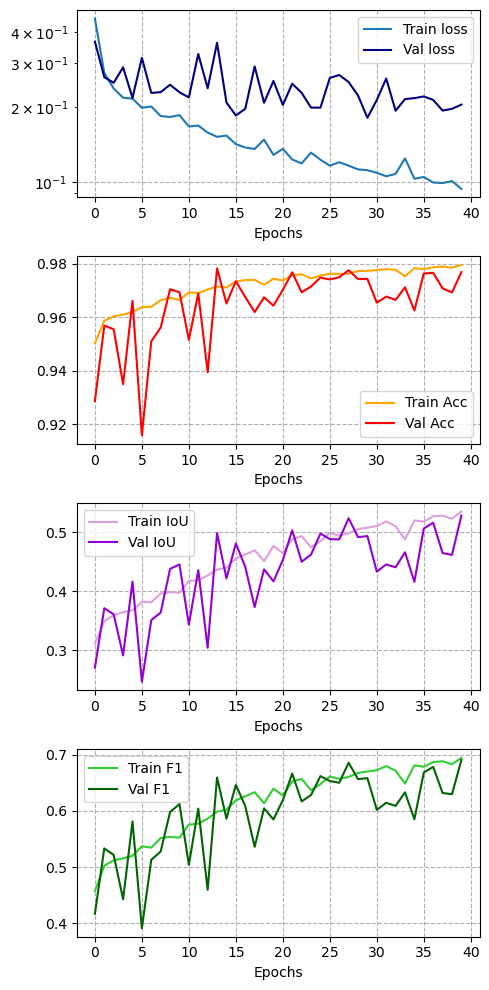

In [28]:
skretch, ax = plt.subplots(4,1,figsize=(5,10))

ax[0].semilogy([mt["loss"] for mt in mytrial_seg_skretch], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial_seg_skretch], label="Val loss", color="navy")

ax[1].plot([mt["binary_acc"] for mt in mytrial_seg_skretch], label="Train Acc", color="orange")
ax[1].plot([mt["val_binary_acc"] for mt in mytrial_seg_skretch], label="Val Acc", color="red")

ax[2].plot([mt["IoU"] for mt in mytrial_seg_skretch], label="Train IoU", color="plum")
ax[2].plot([mt["val_IoU"] for mt in mytrial_seg_skretch], label="Val IoU", color="darkviolet")

ax[3].plot([mt["F1"] for mt in mytrial_seg_skretch], label="Train F1", color="limegreen")
ax[3].plot([mt["val_F1"] for mt in mytrial_seg_skretch], label="Val F1", color="darkgreen")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Segmetation_train_skretch.png")

### Augmetned dataset

In [29]:
np.random.seed(0)
torch.manual_seed(10)



check_skretch_best_aug = Best('checkpoints/Skretch_UNet_aug_bear_best_aug.pth', monitor='val_IoU', mode='max')
check_skretch_last_aug = ModelCheckpoint('checkpoints/Skretch_UNet_aug_bear_last_aug.pth')

model_skretch = model.to(device)

trial_seg_skretch_aug = Trial(model_skretch,
                 optim.Adam(model_skretch.parameters(), lr=5e-04), 
                 nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.045]).to(device)), 
                 metrics=["loss", "acc", "IoU", "F1"],
                 callbacks=[check_skretch_best_aug, check_skretch_last_aug]).to(device)


trial_seg_skretch_aug.load_state_dict(torch.load("checkpoints/Scretch_UNet_aug_bear_last.pth"))
print("net loaded")

net loaded


In [30]:
trial_seg_skretch_aug.with_generators(train_generator=AppD_train_dataloader_aug, 
                          val_generator=AppD_val_dataloader_aug, 
                          test_generator=AppD_test_dataloader)

mytrial_seg_skretch_aug = trial_seg_skretch_aug.run(epochs=100, verbose=2)

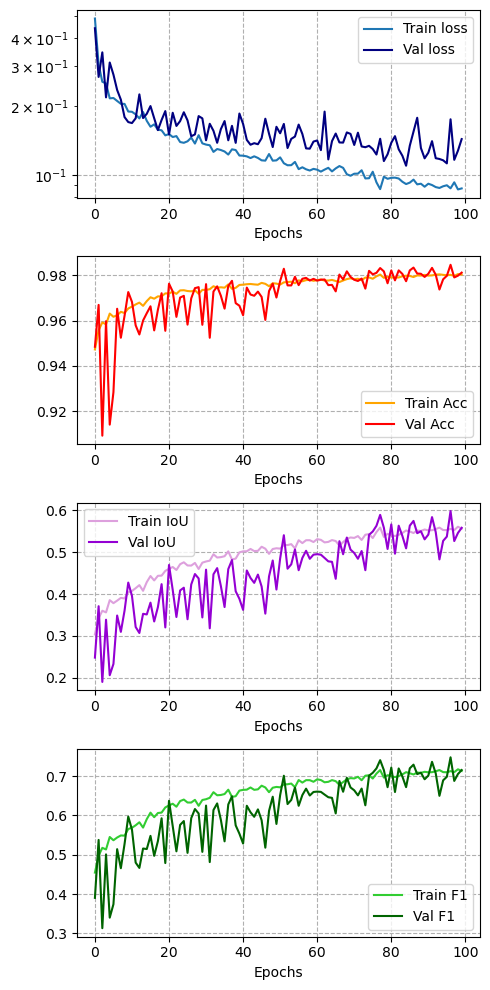

In [31]:
skretch, ax = plt.subplots(4,1,figsize=(5,10))

ax[0].semilogy([mt["loss"] for mt in mytrial_seg_skretch_aug], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial_seg_skretch_aug], label="Val loss", color="navy")

ax[1].plot([mt["binary_acc"] for mt in mytrial_seg_skretch_aug], label="Train Acc", color="orange")
ax[1].plot([mt["val_binary_acc"] for mt in mytrial_seg_skretch_aug], label="Val Acc", color="red")

ax[2].plot([mt["IoU"] for mt in mytrial_seg_skretch_aug], label="Train IoU", color="plum")
ax[2].plot([mt["val_IoU"] for mt in mytrial_seg_skretch_aug], label="Val IoU", color="darkviolet")

ax[3].plot([mt["F1"] for mt in mytrial_seg_skretch_aug], label="Train F1", color="limegreen")
ax[3].plot([mt["val_F1"] for mt in mytrial_seg_skretch_aug], label="Val F1", color="darkgreen")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Segmetation_train_skretch_aug.png")

### Show results

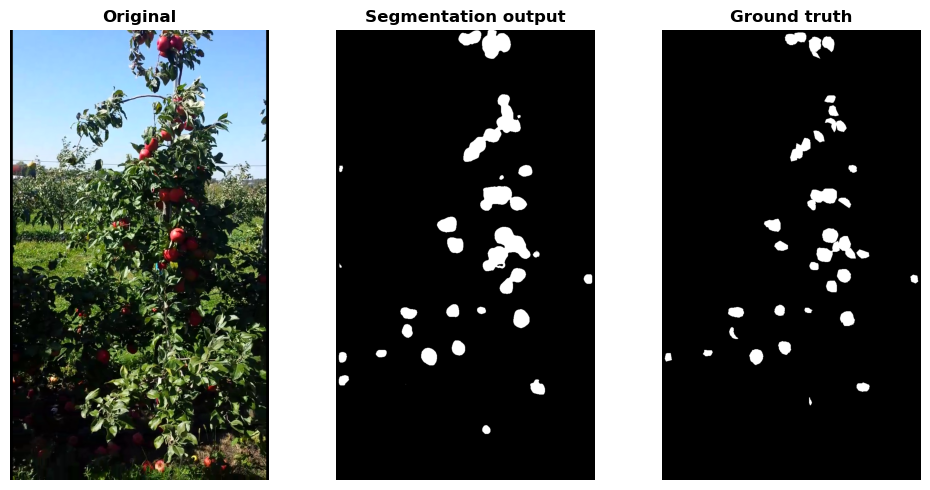

In [32]:
seg_prova, mask_prova = plotSegMask(sample = AppD_val[17],
                                    mytrial = trial_seg_skretch_aug)

# Patching

In [33]:
def createPatches(sample, plot=False):
    image = sample[0].permute(1,2,0).numpy()
    mask = np.array(sample[1].permute(1,2,0).numpy(), dtype=np.uint8)
    contours, _ = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method= cv2.CHAIN_APPROX_SIMPLE)
    
    borders = []
    patches = []
    for con in contours:
        x,y,w,h = cv2.boundingRect(con)
        patches.append(image[y:y+h,x:x+w,:])
        borders.append([x,y,w,h])
    
    borders = np.array(borders)

    if plot:
        image_cont = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2RGBA)
        cv2.drawContours(image_cont, contours, -1, (255,0,0), 1)
        plt.figure(figsize=(17,10))
        plt.imshow(image_cont)
        plt.show()

    return patches, borders

# Counting

## Dataset

In [34]:
class ApplesDatasetCounting(Dataset):
    """Apples Dataset"""

    def __init__(self, csv_file, root_dir, train=True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.train = train
        self.root_dir = root_dir
        if self.train:
            self.summary = pd.read_csv(csv_file)
        else:
            folderIM_content = np.sort(os.listdir(self.root_dir))
            self.summary = pd.DataFrame({ "Image": folderIM_content, "index": np.arange(len(folderIM_content))})
            
        self.transform = transform
        

    def __len__(self):
        return len(self.summary)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.summary.iloc[idx, 0])
        image = io.imread(img_name)

        if self.train:
            label = self.summary.iloc[idx, 1:]
            label = np.array([label])
            label = label.astype('float')
            sample = [image, int(label[0])]
        else:
            sample =[image]
            
        if self.transform:
            sample[0] = self.transform(sample[0])

        return sample

In [35]:
class SquarePad(transforms.Pad):
    def __init__(self, fill=0, padding_mode='constant'):
        super().__init__(0, fill, padding_mode)

    def __call__(self, img):
        c, h, w = img.shape
        if h > w:
            pad_left = 0
            pad_right = 0
            pad_top = (h - w) // 2
            pad_bottom = h - w - pad_top
        else:
            pad_left = (w - h) // 2
            pad_right = w - h - pad_left
            pad_top = 0
            pad_bottom = 0
        padding = (pad_top, pad_left ,pad_bottom, pad_right)
        return transforms.functional.pad(img,padding, 0, 'constant')

### Normal

In [36]:
cnt_transform = transforms.Compose([transforms.ToTensor(),
                                    SquarePad(),
                                    transforms.Resize(64)
                                    ])

COUNTING
Train dataset dimension: 64595
Validation dataset dimension: 3395
Test dataset dimension: 2875
Image size: (3, 64, 64)


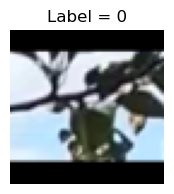

In [37]:
#COUNTING
print("COUNTING")
root = "./"

AppC_train = ApplesDatasetCounting(root+"counting/train/train_ground_truth.txt", 
                                       root+"counting/train/images", 
                                       transform=cnt_transform, 
                                       train=True)

print(f"Train dataset dimension: {len(AppC_train)}")

AppC_val = ApplesDatasetCounting(root+"counting/val/val_ground_truth.txt", 
                                     root+"counting/val/images", 
                                     transform=cnt_transform, 
                                     train=True)

print(f"Validation dataset dimension: {len(AppC_val)}")

AppC_test = ApplesDatasetCounting(csv_file=root+"test_data/counting/ground_truth.txt", 
                                  root_dir=root+"test_data/counting/images", 
                                  transform=cnt_transform, 
                                  train=True)

print(f"Test dataset dimension: {len(AppC_test)}")


# show demostrative image
index = np.random.randint(len(AppC_train))
print("Image size: " + str(AppC_train[index][0].numpy().shape))

plt.figure(figsize=(2,2))
plt.imshow(AppC_train[index][0].permute(1,2,0))
plt.title("Label = %d" % AppC_train[index][1])
plt.axis("off")
plt.show()

#### Dataloaders

In [38]:
# creating dataloaders
batch_size = 30

AppC_train_dataloader = DataLoader(AppC_train, batch_size=batch_size, shuffle=True, num_workers=0)
AppC_val_dataloader = DataLoader(AppC_val, batch_size=batch_size, shuffle=False, num_workers=0)
AppC_test_dataloader = DataLoader(AppC_test, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Number of train batches: {len(AppC_train_dataloader)}")
print(f"Number of val batches: {len(AppC_val_dataloader)}")
print(f"Number of test batches: {len(AppC_val_dataloader)}")

Number of train batches: 2154
Number of val batches: 114
Number of test batches: 114


### Augmented

In [39]:
class CustomTransform:
    def __call__(self, img):
        # convert the image to PIL format
        img = Image.fromarray(np.uint8(img))
        # get the original image size
        w, h = img.size
        img = transforms.RandomResizedCrop(size=(w,h), scale=(0.8, 1.0))(img)
        return img

In [40]:
cnt_aug_transform = transforms.Compose([CustomTransform(),
                                        transforms.ToTensor(),
                                        SquarePad(),
                                        transforms.Resize(64)
                                        ])

In [41]:
print("COUNTING")
root = "./"

AppC_train_aug = ApplesDatasetCounting(root+"counting/train/train_ground_truth.txt", 
                                       root+"counting/train/images", 
                                       transform=cnt_aug_transform, 
                                       train=True)

AppC_val_aug = ApplesDatasetCounting(root+"counting/val/val_ground_truth.txt", 
                                     root+"counting/val/images", 
                                     transform=cnt_aug_transform, 
                                     train=True)

AppC_test_aug = ApplesDatasetCounting(csv_file=root+"test_data/counting/ground_truth.txt", 
                                      root_dir=root+"test_data/counting/images",
                                      transform=cnt_transform, 
                                      train=True)


COUNTING


#### Dataloaders

In [42]:
batch_size = 30

AppC_train_dataloader_aug = DataLoader(AppC_train_aug, batch_size=batch_size, shuffle=True, num_workers=0)
AppC_val_dataloader_aug = DataLoader(AppC_val_aug, batch_size=batch_size, shuffle=False, num_workers=0)
AppC_test_dataloader_aug = DataLoader(AppC_test_aug, batch_size=batch_size, shuffle=False, num_workers=0)

## Model Resnet

In [43]:
model_cnt = nn.Sequential(models.resnet18(), nn.Linear(in_features=1000, out_features=7))

for param_name, param in model_cnt.named_parameters():
    param.requires_grad = False  
    
for param_name, param in model_cnt[0].layer4.named_parameters():
    param.requires_grad = True

for param_name, param in model_cnt[0].avgpool.named_parameters():
    param.requires_grad = True
    
for param_name, param in model_cnt[0].fc.named_parameters():
    param.requires_grad = True

for param_name, param in model_cnt[1].named_parameters():
    param.requires_grad = True

### Training

In [44]:
def ConfusionMatrixPlotAndMetrics(my_trial, dataset_test, dataset_val, image_name):
    ############################
    ####### IMPORTANT ##########
    ############################
    #put shuffle=False in AppC_val_dataloader and run the torchbearer cells before running this one
    ################################################################################################

    Count_Pred_Val = np.argmax(my_trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().cpu().numpy(), axis=1)
    confM_val = confusion_matrix(y_true = np.array(dataset_val.summary["count"]), y_pred = Count_Pred_Val, labels=np.arange(7))

    Count_Pred_Test = np.argmax(my_trial.predict(data_key=torchbearer.TEST_DATA).detach().cpu().numpy(), axis=1)
    confM_test = confusion_matrix(y_true = np.array(dataset_test.summary["count"]), y_pred = Count_Pred_Test, labels=np.arange(7))

    _, ax_conf = plt.subplots(1,2,figsize=(10,5))
    sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma", ax=ax_conf[0])
    ax_conf[0].set_title("VALIDATION", fontweight="bold")
    sns.heatmap(confM_test, annot=True, fmt="g", cbar=False, cmap="magma", ax=ax_conf[1])
    ax_conf[1].set_title("TEST", fontweight="bold")

    [axi.set_xlabel("Y_pred") for axi in ax_conf]
    [axi.set_ylabel("Y_true") for axi in ax_conf]

    plt.savefig("images/"+image_name)
    plt.show()


    cnt_test_acc = accuracy_score(y_true = np.array(dataset_test.summary["count"]), y_pred = Count_Pred_Test)
    cnt_test_F1 = f1_score(y_true = np.array(dataset_test.summary["count"]).astype(np.uint8), y_pred = Count_Pred_Test.astype(np.uint8), average="macro")
    cnt_val_acc = accuracy_score(y_true = np.array(dataset_val.summary["count"]), y_pred = Count_Pred_Val)
    cnt_val_F1 = f1_score(y_true = np.array(dataset_val.summary["count"]).astype(np.uint8), y_pred = Count_Pred_Val.astype(np.uint8), average="macro")

    print("Accuracy Test: %.3f" %(cnt_test_acc))
    print("Accuracy Val: %.3f" %(cnt_val_acc))
    print("F1 score Test: %.3f" %(cnt_test_F1))
    print("F1score Val: %.3f" %(cnt_val_F1))
    
    return {"acc_test": cnt_test_acc, "acc_val": cnt_val_acc, "F1_test": cnt_test_F1, "F1_val": cnt_val_F1}

#### Normal Dataset

In [45]:
np.random.seed(0)
torch.manual_seed(10)

check_best = Best('checkpoints/Class_bear_best_Res.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/Class_bear_last_Res.pth')

model_cnt = model_cnt.to(device)

trial_cnt = Trial(model_cnt,
              optim.Adam(model_cnt.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss", "acc"],
              callbacks=[check_best, check_last]).to(device)

trial_cnt.load_state_dict(torch.load("checkpoints/Class_bear_last_Res.pth"))
print("net loaded")

net loaded


In [46]:
trial_cnt.with_generators(train_generator=AppC_train_dataloader, 
                      val_generator=AppC_val_dataloader, 
                      test_generator=AppC_test_dataloader)

mytrial_cnt = trial_cnt.run(epochs=50, verbose=2)

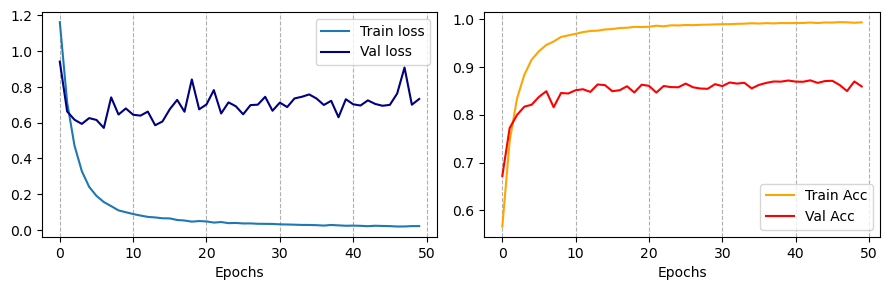

In [47]:
__, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot([mt["loss"] for mt in mytrial_cnt], label="Train loss", color="C0")
ax[0].plot([mt["val_loss"] for mt in mytrial_cnt], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial_cnt], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial_cnt], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(axis="x", ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Counting_train_Res.png")

##### Confusion Matrix

0/1(p):   0%|          | 0/114 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/96 [00:00<?, ?it/s]

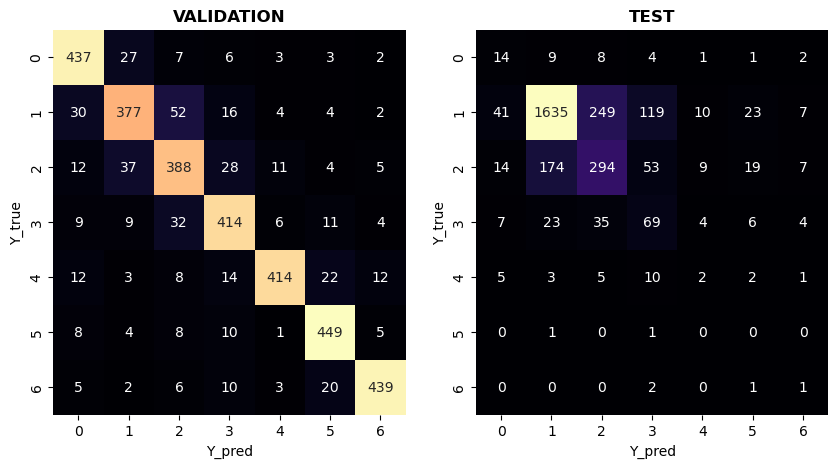

Accuracy Test: 0.701
Accuracy Val: 0.859
F1 score Test: 0.295
F1score Val: 0.860


In [48]:
class_normal_metrics = ConfusionMatrixPlotAndMetrics(my_trial=trial_cnt, 
                                                     dataset_test = AppC_test, 
                                                     dataset_val = AppC_val,
                                                    image_name="ConMat_Res_Norm.png")

#### Augmented Dataset

In [49]:
np.random.seed(0)
torch.manual_seed(10)

check_best = Best('checkpoints/Class_bear_best_Res_aug.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/Class_bear_last_Res_aug.pth')

model_cnt = model_cnt.to(device)

trial_cnt_aug = Trial(model_cnt,
              optim.Adam(model_cnt.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss", "acc"],
              callbacks=[check_best, check_last]).to(device)

trial_cnt_aug.load_state_dict(torch.load("checkpoints/Class_bear_last_Res_aug.pth"))
print("net loaded")

net loaded


In [50]:
trial_cnt_aug.with_generators(train_generator=AppC_train_dataloader_aug, 
                      val_generator=AppC_val_dataloader_aug, 
                      test_generator=AppC_test_dataloader_aug)

mytrial_cnt_aug = trial_cnt_aug.run(epochs=50, verbose=2)

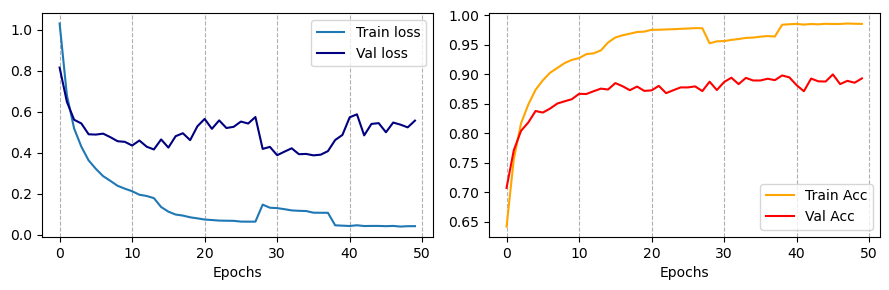

In [51]:
__, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot([mt["loss"] for mt in mytrial_cnt_aug], label="Train loss", color="C0")
ax[0].plot([mt["val_loss"] for mt in mytrial_cnt_aug], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial_cnt_aug], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial_cnt_aug], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(axis="x", ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Counting_train_Res_aug.png")

##### Confusion Matrix

0/1(p):   0%|          | 0/114 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/96 [00:00<?, ?it/s]

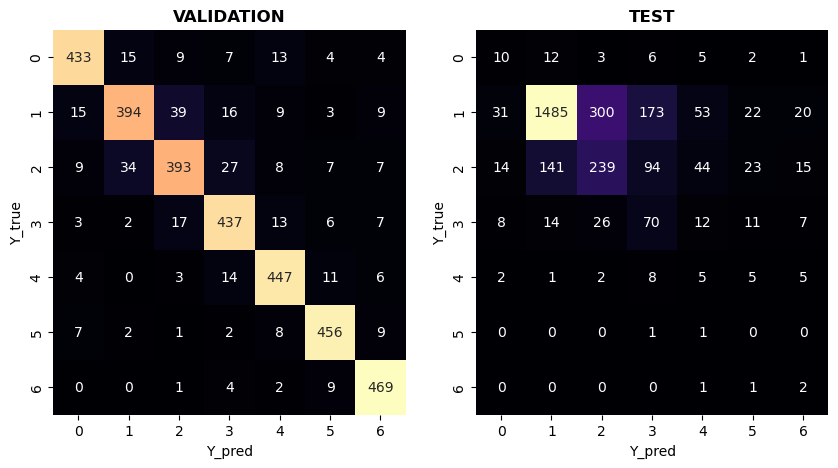

Accuracy Test: 0.630
Accuracy Val: 0.892
F1 score Test: 0.261
F1score Val: 0.892


In [52]:
class_aug_metrics = ConfusionMatrixPlotAndMetrics(my_trial=trial_cnt_aug, 
                                                     dataset_test = AppC_test_aug, 
                                                     dataset_val = AppC_val_aug,
                                                     image_name="ConMat_Res_aug.png")

## Model Skretch

In [53]:
class Model_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120) # 13x13 output from conv2
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_cnt = Model_conv()
model_cnt.to(device)

Model_conv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

### Training

#### Normal Dataset

In [54]:
np.random.seed(0)
torch.manual_seed(10)

check_best = Best('checkpoints/Skretch_Class_bear_best.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/Skretch_Class_bear_last.pth')

model_cnt = model_cnt.to(device)

trial_cnt = Trial(model_cnt,
              optim.Adam(model_cnt.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss", "acc"],
              callbacks=[check_best, check_last]).to(device)

trial_cnt.load_state_dict(torch.load("checkpoints/Skretch_Class_bear_last.pth"))
print("net loaded")

net loaded


In [55]:
trial_cnt.with_generators(train_generator=AppC_train_dataloader, 
                      val_generator=AppC_val_dataloader, 
                      test_generator=AppC_test_dataloader)

mytrial_cnt = trial_cnt.run(epochs=50, verbose=2)

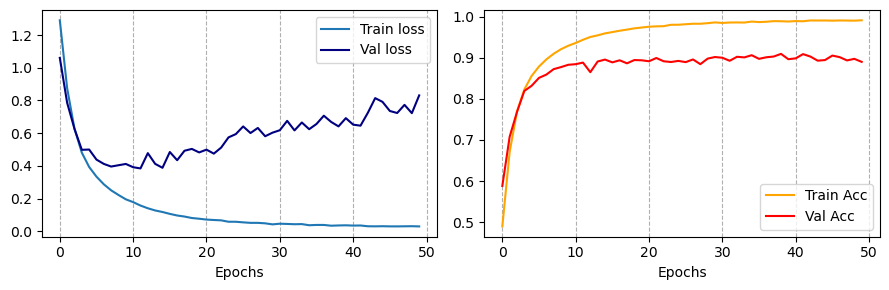

In [56]:
__, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot([mt["loss"] for mt in mytrial_cnt], label="Train loss", color="C0")
ax[0].plot([mt["val_loss"] for mt in mytrial_cnt], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial_cnt], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial_cnt], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(axis="x", ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Skretch_Counting_train_Res.png")

##### Confusion Matrix

0/1(p):   0%|          | 0/114 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/96 [00:00<?, ?it/s]

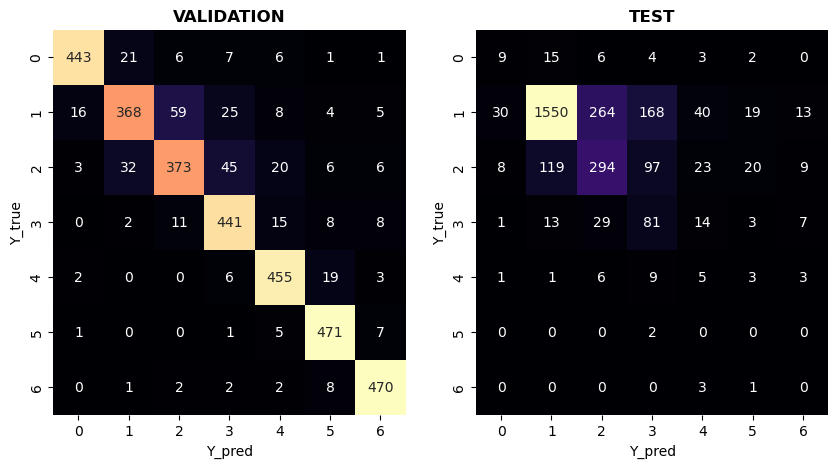

Accuracy Test: 0.674
Accuracy Val: 0.890
F1 score Test: 0.276
F1score Val: 0.888


In [57]:
class_scretch_normal_metrics = ConfusionMatrixPlotAndMetrics(my_trial=trial_cnt, 
                                                     dataset_test = AppC_test, 
                                                     dataset_val = AppC_val, image_name="Skretch_ConMat_Res.png")

#### Augmented Dataset

In [58]:
np.random.seed(0)
torch.manual_seed(10)

check_best = Best('checkpoints/Skretch_Class_bear_best_aug_Res.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/Skretch_Class_bear_last_aug_Res.pth')

model_cnt = model_cnt.to(device)

trial_cnt = Trial(model_cnt,
              optim.Adam(model_cnt.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss", "acc"],
              callbacks=[check_best, check_last]).to(device)

trial_cnt.load_state_dict(torch.load("checkpoints/Skretch_Class_bear_last_aug_Res.pth"))
print("net loaded")

net loaded


In [59]:
trial_cnt.with_generators(train_generator=AppC_train_dataloader_aug, 
                      val_generator=AppC_val_dataloader_aug, 
                      test_generator=AppC_test_dataloader_aug)

mytrial_cnt = trial_cnt.run(epochs=50, verbose=2)

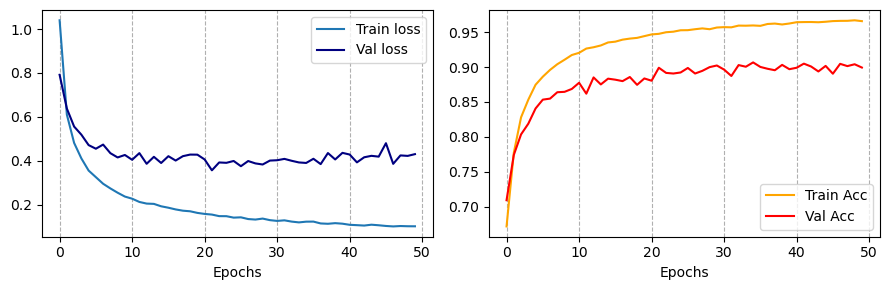

In [60]:
__, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot([mt["loss"] for mt in mytrial_cnt], label="Train loss", color="C0")
ax[0].plot([mt["val_loss"] for mt in mytrial_cnt], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial_cnt], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial_cnt], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(axis="x", ls="--") for axi in ax]

plt.tight_layout()
plt.savefig("images/Skretch_Counting_train_aug_Res.png")

##### Confusion Matrix

0/1(p):   0%|          | 0/114 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/96 [00:00<?, ?it/s]

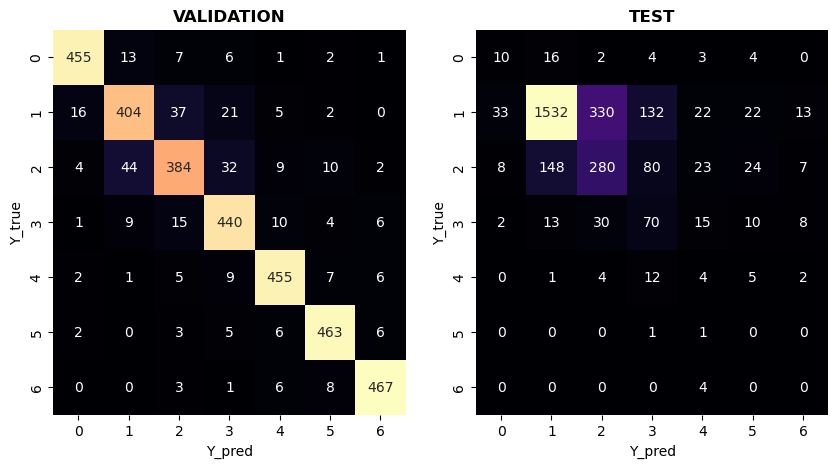

Accuracy Test: 0.659
Accuracy Val: 0.904
F1 score Test: 0.268
F1score Val: 0.903


In [61]:
class_normal_metrics = ConfusionMatrixPlotAndMetrics(my_trial=trial_cnt, 
                                                     dataset_test = AppC_test, 
                                                     dataset_val = AppC_val,
                                                    image_name = 'Skretch_ConMat_Res_aug.png')

# Depth Estimation

In [62]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
print("net depth")

Using cache found in /home/francesco/.cache/torch/hub/intel-isl_MiDaS_master


net depth


# Combining

In [63]:
def CountApples(sample, trial_seg, trial_class, depth_model, folder="test_data/segmentation/", depth_thresh=True):
    image = cv2.imread(folder+"images/"+sample)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.pad(image, ((0,0), (8,8), (0,0)), "constant", constant_values=0)
    image = seg_transform(image)
    mask = cv2.imread(folder+"masks/"+sample)
    
    #segmentation
    model_smp = trial_seg.state[torchbearer.state.MODEL]

    with torch.no_grad():
        out_segm = nn.Sigmoid()(model_smp(image.unsqueeze(0).to(device)).detach().cpu())
        if depth_thresh: dept_est = depth_model(image.unsqueeze(0).to(device)).detach().cpu().numpy()
    
    out_segm = (out_segm>0.5).float()
    
    if depth_thresh:
        dept_est[:,:1000,:][dept_est[:,:1000,:]<12]=0
        dept_est[:,:1000,:][dept_est[:,:1000,:]!=0]=1
        dept_est[:,1000:,:][dept_est[:,1000:,:]<20]=0
        dept_est[:,1000:,:][dept_est[:,1000:,:]!=0]=1
    
        out_segm = out_segm*dept_est

    #patches creation
    patches, borders = createPatches([image, out_segm[0]])
    
    #patches classification
    model_cnt = trial_class.state[torchbearer.state.MODEL]
    model_cnt.eval()
    
    count=[]
    len_p = []

    for i in range(len(patches)):
        len_p.append(patches[i].size)
        if patches[i].size>150:
            reshaped_patch = cnt_transform(patches[i])
            out_c = model_cnt(reshaped_patch.unsqueeze(0).to(device)).detach().cpu().numpy()
            count.append(np.argmax(out_c))
            
    
    return sum(count), len(np.unique(mask)), out_segm

68
31


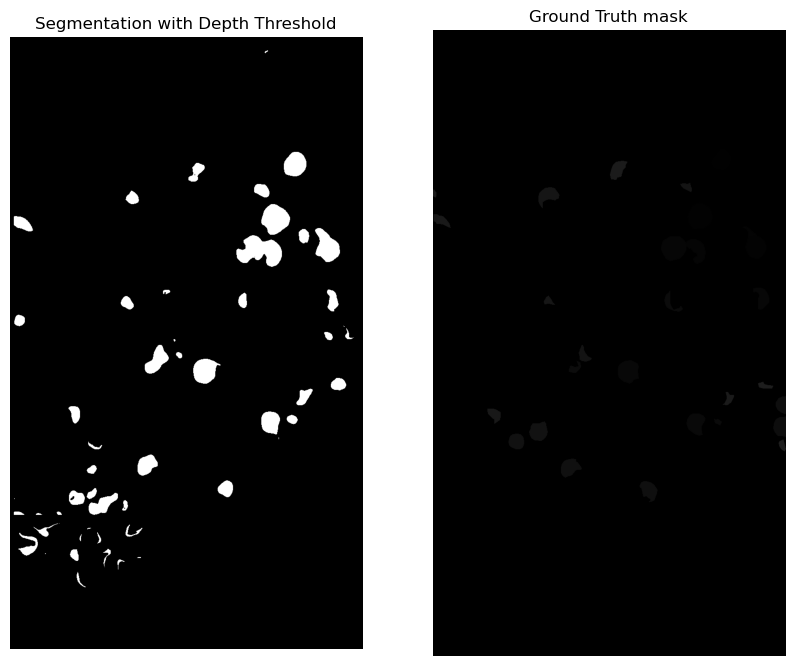

In [64]:
smp = AppDetect_test.summary["images"][10]

cnt_s, cnt_m, out_seg = CountApples(sample=smp,
                                    trial_seg = trial_seg_aug,
                                    trial_class = trial_cnt,
                                    depth_model=midas,
                                    folder="test_data/segmentation/",
                                    depth_thresh=True)


plt.figure(figsize=(10,10))
msk = (cv2.imread("test_data/segmentation/masks/"+smp))
plt.subplot(1,2,1)
plt.imshow(out_seg[0][0], cmap="gray"), plt.axis("off")
plt.title("Segmentation with Depth Threshold")
plt.subplot(1,2,2)
plt.imshow(msk), plt.axis("off")
plt.title("Ground Truth mask")
print(cnt_s)
print(cnt_m)
#plt.savefig("images/seg_with_dThresh.png")

In [65]:
def CountingOnDataset(names_list, trial_seg, trial_class, depth_model, folder, save=False, save_name="final_data.txt", depth_thresh=True):
    count_gt, count_seg = [],[]

    for smp in tqdm(names_list):
        cnt, cnt_m, oou = CountApples(sample = smp,
                                      trial_seg = trial_seg,
                                      trial_class = trial_class,
                                      depth_model= depth_model,
                                      folder = folder,
                                      depth_thresh=depth_thresh)

        count_seg.append(cnt)
        count_gt.append(cnt_m)

    count_gt = np.array(count_gt)
    count_seg = np.array(count_seg)

    count_diff = count_gt-count_seg
    apple_count_df = pd.DataFrame({"Napp_seg":count_seg, "Napp_gt":count_gt, "Diff": count_diff})
    
    if save:
        np.savetxt(X=apple_count_df, fname=save_name, header="Napp_seg Napp_gt Diff", comments="", fmt="%d")
        
    return apple_count_df

## Validation

In [ ]:
apple_count_val_df = CountingOnDataset(names_list=list(AppDetect_train.summary.iloc[AppD_val.indices,:]["images"]),
                                        trial_seg = trial_seg_aug,
                                        trial_class = trial_cnt,
                                        folder="detection/train/",
                                        save=True,
                                        save_name="final_res/final_val_nodept.txt",
                                        depth_model=midas,
                                        depth_thresh=False)

## Test

In [ ]:
apple_count_test_dept_df = CountingOnDataset(names_list=list(AppDetect_test.summary["images"]),
                                        trial_seg = trial_seg_aug,
                                        trial_class = trial_cnt,
                                        depth_model=midas,
                                        save=True,
                                        folder="test_data/segmentation/",
                                        save_name="final_res/final_test_nodept.txt",
                                        depth_thresh=False)

#apple_count_test_df = pd.read_csv("final_test.txt", header=0, sep=" ")

## Results

In [66]:
apple_count_test_dept_df = pd.read_csv("final_res/final_test_dept.txt", header=0, sep=" ")
apple_count_test_nodept_df = pd.read_csv("final_res/final_test_nodept.txt", header=0, sep=" ")
apple_count_val_dept_df = pd.read_csv("final_res/final_val_dept.txt", header=0, sep=" ")
apple_count_val_nodept_df = pd.read_csv("final_res/final_val_nodept.txt", header=0, sep=" ")

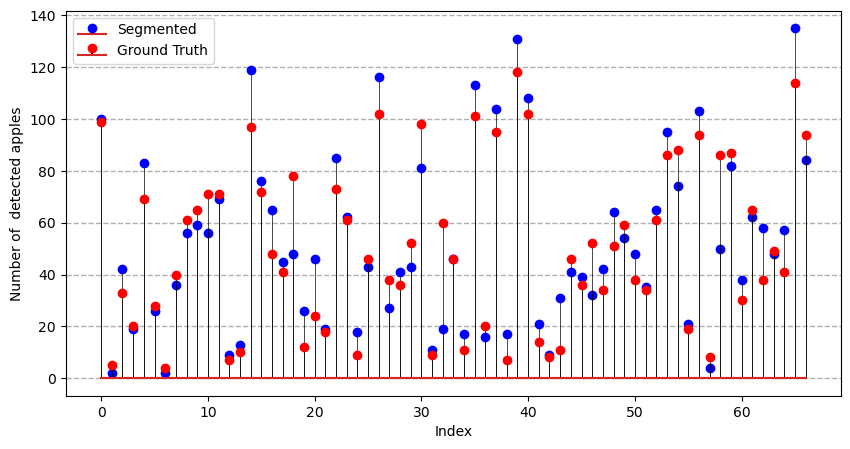

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
markerline_s, stemlines_s, baseline_s = ax.stem(apple_count_val_dept_df["Napp_seg"], label="Segmented")
plt.setp(markerline_s, 'color', 'blue')
plt.setp(stemlines_s, 'linewidth', 0.5)
plt.setp(stemlines_s, 'color', 'k')
#plt.setp(baseline, 'linewidth', 2)

markerline_g, stemlines_g, baseline_g = ax.stem(apple_count_val_dept_df["Napp_gt"], label="Ground Truth")
plt.setp(markerline_g, 'color', 'red')
plt.setp(stemlines_g, 'linewidth', 0.5)
plt.setp(stemlines_g, 'color', 'k')

plt.xlabel("Index")
plt.ylabel("Number of  detected apples")
plt.legend()
plt.grid(axis="y", ls="--", lw=1)
plt.savefig("images/final_dep_val_aug.png")
plt.show()

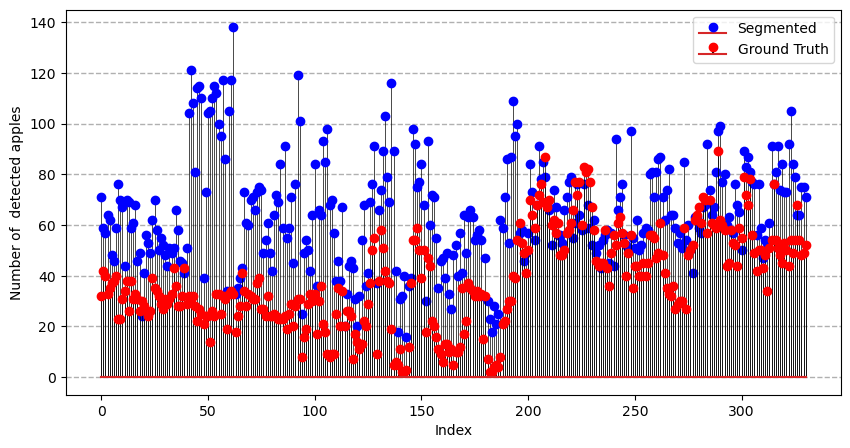

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
markerline_s, stemlines_s, baseline_s = ax.stem(apple_count_test_dept_df["Napp_seg"], label="Segmented")
plt.setp(markerline_s, 'color', 'blue')
plt.setp(stemlines_s, 'linewidth', 0.5)
plt.setp(stemlines_s, 'color', 'k')
#plt.setp(baseline, 'linewidth', 2)

markerline_g, stemlines_g, baseline_g = ax.stem(apple_count_test_dept_df["Napp_gt"], label="Ground Truth")
plt.setp(markerline_g, 'color', 'red')
plt.setp(stemlines_g, 'linewidth', 0.5)
plt.setp(stemlines_g, 'color', 'k')

plt.xlabel("Index")
plt.ylabel("Number of  detected apples")
plt.legend()
plt.grid(axis="y", ls="--", lw=1)
plt.savefig("images/final_dep_test_aug.png")
plt.show()

In [67]:
ttst_val_dept = ttest_ind(apple_count_test_dept_df["Napp_seg"], apple_count_test_dept_df["Napp_gt"])
ttst_val_nodept = ttest_ind(apple_count_test_nodept_df["Napp_seg"], apple_count_test_nodept_df["Napp_gt"])
ttst_test_dept = ttest_ind(apple_count_val_dept_df["Napp_seg"], apple_count_val_dept_df["Napp_gt"])
ttst_test_nodept = ttest_ind(apple_count_val_nodept_df["Napp_seg"], apple_count_val_nodept_df["Napp_gt"])

In [68]:
print("T-test, test with depth filtering: %.4f" %ttst_val_dept.statistic)
print("T-test, test without depth filtering: %.4f" %ttst_val_nodept.statistic)

print("T-test, val with depth filtering: %.4f" %ttst_test_dept.statistic)
print("T-test, val without depth filtering: %.4f" %ttst_test_nodept.statistic)


T-test, test with depth filtering: 16.8481
T-test, test without depth filtering: 24.5601
T-test, val with depth filtering: 0.2790
T-test, val without depth filtering: 1.8942


In [69]:
print(f"p-value, test with depth filtering: {ttst_val_dept.pvalue}")
print(f"p-value, test without depth filtering: {ttst_val_nodept.pvalue}")

print(f"p-value, val with depth filtering: {ttst_test_dept.pvalue}")
print(f"p-value, val without depth filtering: {ttst_test_nodept.pvalue}")


p-value, test with depth filtering: 3.033042067362599e-53
p-value, test without depth filtering: 4.12846150864337e-95
p-value, val with depth filtering: 0.7806591837479316
p-value, val without depth filtering: 0.06038496787036784


# Image merging

In [77]:
dataD = AppDetect_test.summary
dataD

d1f_images_list = []
d1b_images_list = []
d2f_images_list = []
d2b_images_list = []
d3f_images_list = []
d3b_images_list = []
d4f_images_list = []

def sort_key(string):
    return int(string.split("_")[2].split(".")[0])

d1f_images_list.sort(key=sort_key)
d1f_images_list

for i in range(len(dataD)):
    if "dataset1_front" in dataD["images"][i]:
        d1f_images_list.append(dataD["images"][i])
    elif "dataset1_back" in dataD["images"][i]:
        d1b_images_list.append(dataD["images"][i])
    elif "dataset2_front" in dataD["images"][i]:
        d2f_images_list.append(dataD["images"][i])
    elif "dataset2_back" in dataD["images"][i]:
        d2b_images_list.append(dataD["images"][i])
    elif "dataset3_front" in dataD["images"][i]:
        d3f_images_list.append(dataD["images"][i])
    elif "dataset3_back" in dataD["images"][i]:
        d3b_images_list.append(dataD["images"][i])
    elif "dataset4_front" in dataD["images"][i]:
        d4f_images_list.append(dataD["images"][i])

d1f_images_list.sort(key=sort_key)
d1b_images_list.sort(key=sort_key)
d2f_images_list.sort(key=sort_key)
d2b_images_list.sort(key=sort_key)
d3f_images_list.sort(key=sort_key)
d3b_images_list.sort(key=sort_key)
d4f_images_list.sort(key=sort_key)

print(f"Nr. images dataset 1 front {len(d1f_images_list)}")
print(f"Nr. images dataset 1 back {len(d1b_images_list)}")
print(f"Nr. images dataset 2 front {len(d2f_images_list)}")
print(f"Nr. images dataset 2 back {len(d2b_images_list)}")
print(f"Nr. images dataset 3 front {len(d3f_images_list)}")
print(f"Nr. images dataset 3 back {len(d3b_images_list)}")
print(f"Nr. images dataset 4 front {len(d4f_images_list)}")

Nr. images dataset 1 front 54
Nr. images dataset 1 back 40
Nr. images dataset 2 front 51
Nr. images dataset 2 back 51
Nr. images dataset 3 front 48
Nr. images dataset 3 back 45
Nr. images dataset 4 front 42


# Overplap maximization

In [78]:
def Superposition_Transforation(img1, img2, traslation_X, traslation_Y, scale=1, rotation=0, img_ret = False):
    
    # Perform the rotation
    M_rot = cv2.getRotationMatrix2D((img1.shape[1] / 2, img1.shape[0] / 2), rotation, 1)
    img1 = cv2.warpAffine(img1, M_rot, (img1.shape[1], img1.shape[0]))
    # Perform the translation
    M = np.float32([[scale, 0, traslation_X], [0, scale, traslation_Y]])
    img1 = cv2.warpAffine(img1, M, (img1.shape[1], img1.shape[0]))
    
    # Compute metric for Superposition
    overlap = np.minimum(img1 + img2, np.ones_like(img1))
    intersection = img1*img2
    superposition = (intersection.sum()/overlap.sum())
    
    if img_ret:
        return superposition, np.array(img1, dtype=np.uint8), np.array(img2, dtype=np.uint8)
    
    return superposition

In [79]:
def MyOptimization(img1, img2, ntrials=1000, printt=True):
    np.random.seed(0)
    torch.manual_seed(10)

    trial_log = []

    def trial_callback(trial):
        trial.log.append([trial.value()])


    def objective(trial):

        # set the range of the transformations to apply to the image
        hyperparameters = [
            trial.suggest_int("traslation_X", 0, 500),
            trial.suggest_int("traslation_Y", -100, 100),
            trial.suggest_float("scale", 0.7, 1.1),
            trial.suggest_float("rotation", -10, 10)
        ]


        superposition = Superposition_Transforation(img1, img2,
                                                traslation_X=hyperparameters[0], 
                                                traslation_Y=hyperparameters[1],
                                                scale=hyperparameters[2],
                                                rotation=hyperparameters[2]
                                                )

        return superposition

    pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
    sampler = TPESampler(seed=100)
    study = optuna.create_study(study_name="Superposition optimization", direction="maximize", pruner=pruner, sampler=sampler)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials=ntrials)
    
    if printt:
        print("Number of finished trials: {}".format(len(study.trials)))

        print("Best trial:")
        trial = study.best_trial

        print("   Max IoU: {}".format(trial.value))

        print("   Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))

    return study

#study = MyOptimization(seg0_1f[0][0].numpy(), seg1_1f[0][0].numpy())

In [80]:
def countOverlApples(sample0, sample1):
    cnt_1, __, seg = CountApples(sample=sample0,
                            trial_seg = trial_seg_aug,
                            trial_class = trial_cnt,
                            depth_model=midas,
                            depth_thresh=True)

    cnt_2, _, seg1 = CountApples(sample=sample1,
                                trial_seg = trial_seg_aug,
                                trial_class = trial_cnt,
                                depth_model=midas,
                                depth_thresh=True)
    
    study = MyOptimization(seg[0][0].numpy(), seg1[0][0].numpy())
    
    count=[]
    index = AppDetect_test.summary[AppDetect_test.summary["images"]==sample0]["index"].to_numpy()[0]
    pa, bo = createPatches(AppDetect_test[index])
    _, imt1, imt2 = Superposition_Transforation(seg[0][0].numpy(), seg1[0][0].numpy(), *list(study.best_trial.params.values()), img_ret=True)
    for i in range(len(bo)):
        x,y,w,h = bo[i]
        provv_seg = np.copy(seg[0][0].numpy())
        zeros_seg = np.zeros_like(provv_seg)
        zeros_seg[y:y+h, x:x+w] = provv_seg[y:y+h, x:x+w]
        _, i1, i2 = Superposition_Transforation(zeros_seg, seg1[0][0].numpy(), *list(study.best_trial.params.values()), img_ret=True)
        overl = (i1*i2).sum()/zeros_seg.sum()
        
        if overl>0.4:
            reshaped_patch = cnt_transform(pa[i])
            out_c = model_cnt(reshaped_patch.unsqueeze(0).to(device)).detach().cpu().numpy()
            count.append(np.argmax(out_c))
            
    return [cnt_1,cnt_2,sum(count)], imt1, imt2, study

In [81]:
c, i1, i2, study01 = countOverlApples(d1f_images_list[0], d1f_images_list[1])

[I 2023-03-06 18:37:07,294] A new study created in memory with name: Superposition optimization


Number of finished trials: 1000
Best trial:
   Max IoU: 0.28853073716163635
   Params: 
    traslation_X: 83
    traslation_Y: 16
    scale: 0.9591379900342553
    rotation: 1.7433262822364721


<Figure size 800x300 with 0 Axes>

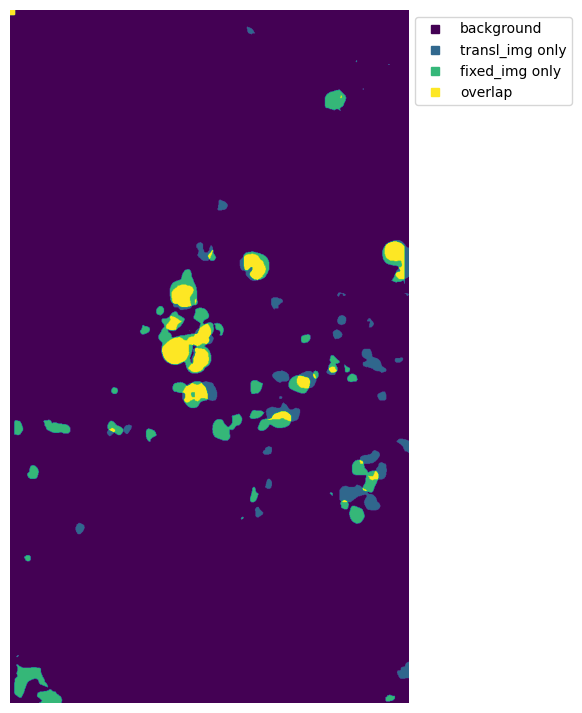

In [82]:
plt.figure(figsize=(8,3))
plt.figure(figsize=(15,9))
plt.imshow(i1+(2*i2), cmap="viridis"), plt.axis("off")
color_map = {0: 'background', 1: 'transl_img only', 2: 'fixed_img only', 3: 'overlap'}

# Create a list of the color names, in the order they appear in the color map
color_names = [color_map[color] for color in np.unique(i1+(2*i2))]

# Create a list of patches, one for each color
patches = [plt.plot([0], [0], marker='s', color=plt.get_cmap('viridis')(i/3), ls="")[0] for i in range(4)]

# Add the legend to the plot
plt.legend(patches, color_names, numpoints=1, loc="upper left", bbox_to_anchor=(1, 1))

plt.savefig("SuperMax.png")
plt.show()

In [83]:

def plotParamSpace(study, pairplot=True, pca=False):
    acc_log = [t.value for t in study.trials]
    param_log = [[t.params["traslation_X"],t.params["traslation_Y"],t.params["scale"],t.params["rotation"], t.value] for t in study.trials]
    param_log = np.array(param_log)
    param_log_df = pd.DataFrame(param_log, columns=["traslation_X", "traslation_Y", "scale", "rotation", "IoU"])

    if pairplot:
        plt.figure(figsize=(10,7))

        _ , axscatt = plt.subplots(2,3,figsize=(17,12))
        axscatt = axscatt.flatten()

        combinations = [["traslation_X", "traslation_Y"],
                        ["traslation_X", "scale"],
                        ["traslation_X", "rotation"],
                        ["traslation_Y", "scale"],
                        ["traslation_Y", "rotation"],
                        ["scale", "rotation"]
                        ]

        for i in range(len(combinations)):
            sns.scatterplot(data = param_log_df, 
                            x=combinations[i][0], 
                            y = combinations[i][1], 
                            size="IoU",
                            hue=np.arange(len(param_log_df), dtype=np.float32), 
                            palette=sns.color_palette("Spectral_r", as_cmap=True),
                            legend=False,
                            sizes=(10,150),
                            ax=axscatt[i]
                            )
        plt.show()

    if pca:
        plt.figure(figsize=(8,6))
        pca = PCA(n_components=2)
        x = pca.fit_transform(param_log_df)
        param_log_pca_df = pd.DataFrame(np.vstack([x[:,0], x[:,1], acc_log]).T, columns=["PCA 1", "PCA 2", "IoU"])
        sns.scatterplot(data=param_log_pca_df, 
                        x="PCA 1", y="PCA 2", 
                        hue=np.arange(len(param_log_pca_df)), 
                        size="IoU", sizes=(15,100), 
                        palette="Spectral_r",
                        legend=False)
        plt.show()


<Figure size 1000x700 with 0 Axes>

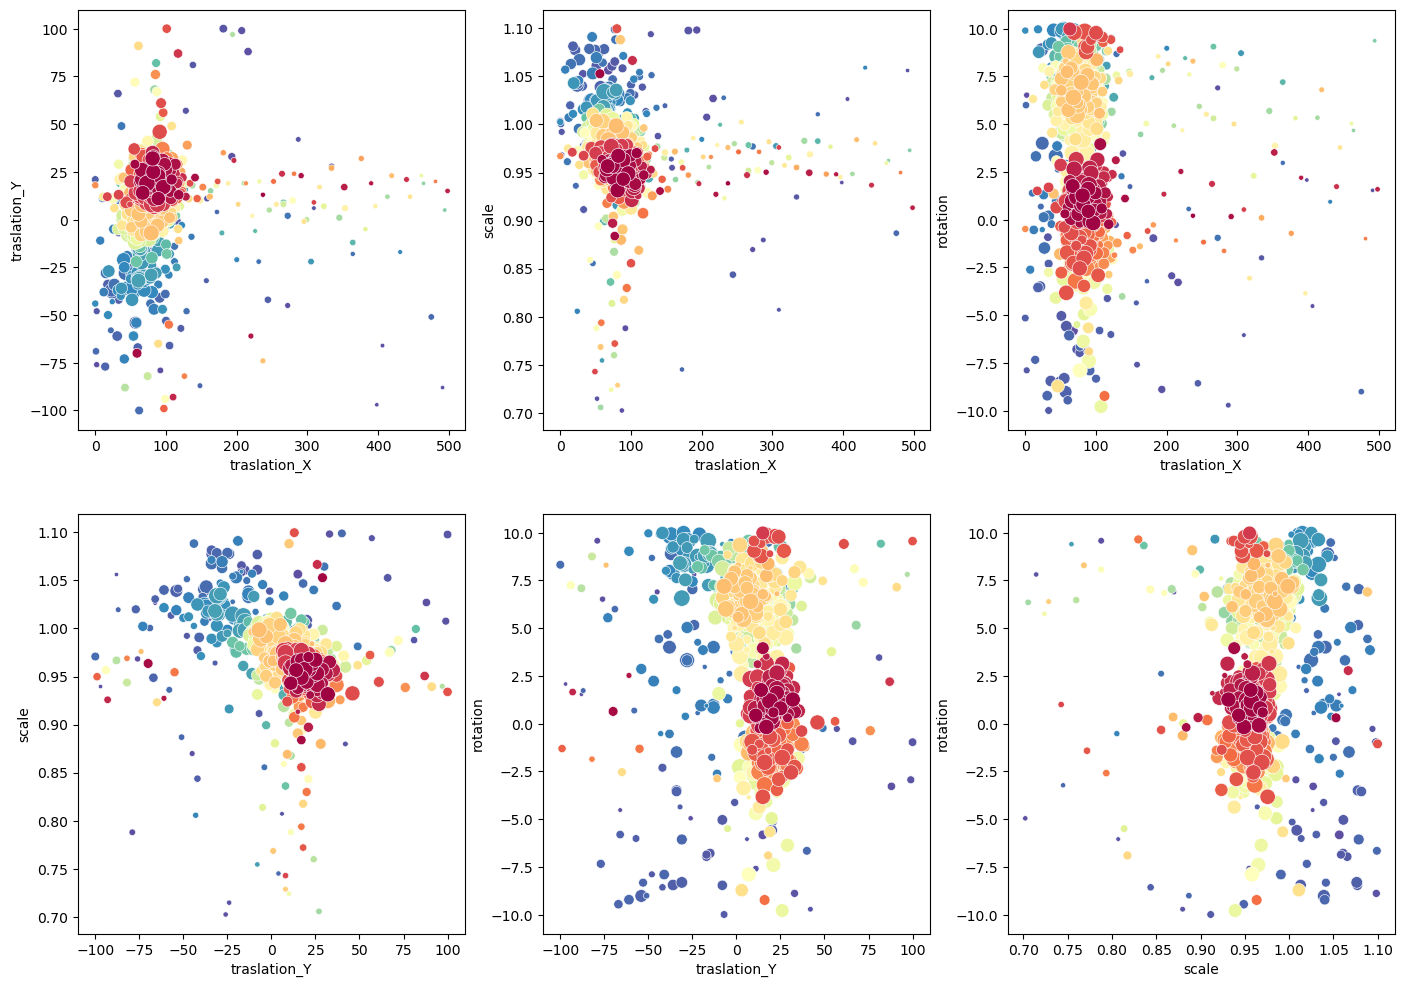

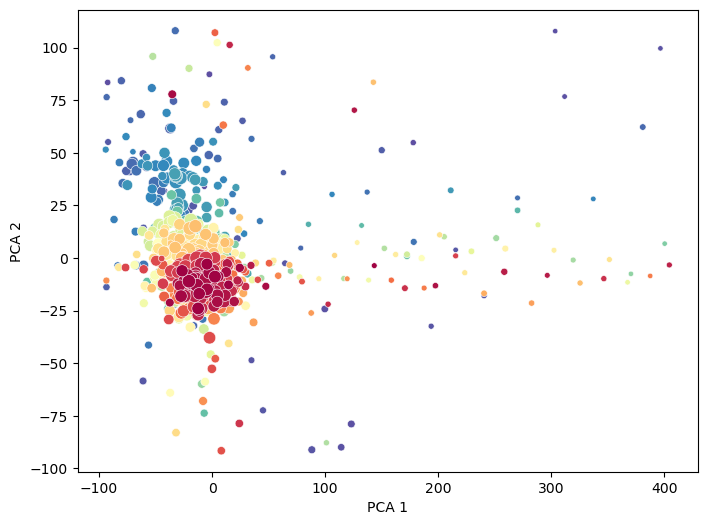

In [84]:
plotParamSpace(study=study01, pairplot=True, pca=True)